# Trajectory Recommendation using POI Ranking and Active Learning

## 1. Overview

1. Rank POIs using rankSVM
1. Recommend a set of POIs given (start, end, length)

In [1]:
% matplotlib inline

import os, re, sys, time, pickle, tempfile
import math, random, itertools, scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sop
from joblib import Parallel, delayed

In [2]:
random.seed(987654321) # control random choice when splitting training/testing set
np.random.seed(987654321)
ranksvm_dir = '$HOME/work/ranksvm'

In [3]:
data_dir = 'data/data-ijcai15'
#fvisit = os.path.join(data_dir, 'userVisits-Osak.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Osak.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Glas.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Glas.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Edin.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Edin.csv')
fvisit = os.path.join(data_dir, 'userVisits-Toro.csv')
fcoord = os.path.join(data_dir, 'photoCoords-Toro.csv')

In [4]:
suffix = fvisit.split('-')[-1].split('.')[0]
fseqpart = os.path.join(data_dir, 'seqPart-' + suffix + '.pkl')

In [5]:
visits = pd.read_csv(fvisit, sep=';')
coords = pd.read_csv(fcoord, sep=';')
assert(visits.shape[0] == coords.shape[0])
traj = pd.merge(visits, coords, on='photoID') # merge data frames according to column 'photoID'
#traj.head()

In [6]:
num_photo = traj['photoID'].unique().shape[0]
num_user = traj['userID'].unique().shape[0]
num_poi = traj['poiID'].unique().shape[0]
num_seq = traj['seqID'].unique().shape[0]
pd.DataFrame({'#photo': num_photo, '#user': num_user, '#poi': num_poi, '#seq': num_seq, \
              '#photo/user': num_photo/num_user, '#seq/user': num_seq/num_user}, index=[str(suffix)])

,#photo,#photo/user,#poi,#seq,#seq/user,#user
Toro,39419,28.257348,29,6057,4.341935,1395


## 2.1 Compute POI Information

Compute POI (Longitude, Latitude) as the average coordinates of the assigned photos.

In [7]:
poi_coords = traj[['poiID', 'photoLon', 'photoLat']].groupby('poiID').mean()
poi_coords.reset_index(inplace=True)
poi_coords.rename(columns={'photoLon':'poiLon', 'photoLat':'poiLat'}, inplace=True)

Extract POI category and visiting frequency.

In [8]:
poi_catfreq = traj[['poiID', 'poiTheme', 'poiFreq']].groupby('poiID').first()
poi_catfreq.reset_index(inplace=True)

In [9]:
poi_all = pd.merge(poi_catfreq, poi_coords, on='poiID')
poi_all.set_index('poiID', inplace=True)
poi_all.head()
#poi_all.to_csv(fpoi, index=True)

,poiTheme,poiFreq,poiLon,poiLat
poiID,,,,
1,Sport,3506,-79.379243,43.643183
2,Sport,609,-79.418634,43.632772
3,Sport,688,-79.380045,43.662175
4,Sport,3056,-79.389290,43.641297
6,Cultural,986,-79.392396,43.653662


## 2.2 Construct Travelling Sequences

In [10]:
seq_all = traj[['userID', 'seqID', 'poiID', 'dateTaken']].copy().groupby(['userID', 'seqID', 'poiID'])\
          .agg([np.min, np.max, np.size])
seq_all.columns = seq_all.columns.droplevel()
seq_all.reset_index(inplace=True)
seq_all.rename(columns={'amin':'arrivalTime', 'amax':'departureTime', 'size':'#photo'}, inplace=True)
seq_all['poiDuration(sec)'] = seq_all['departureTime'] - seq_all['arrivalTime']
seq_all.head()

,userID,seqID,poiID,arrivalTime,departureTime,#photo,poiDuration(sec)
0,10007579@N00,1,30,1346844688,1346844688,1,0
1,10012675@N05,2,6,1142731848,1142732445,4,597
2,10012675@N05,3,6,1142916492,1142916492,1,0
3,10012675@N05,4,13,1319327174,1319332848,9,5674
4,10014440@N06,5,24,1196128621,1196128878,3,257


In [11]:
seq_stats = seq_all[['userID', 'seqID', 'poiID']].copy().groupby(['userID', 'seqID']).agg(np.size)
seq_stats.reset_index(inplace=True)
seq_stats.rename(columns={'poiID':'seqLen'}, inplace=True)
seq_stats.set_index('seqID', inplace=True)
seq_stats.head()

,userID,seqLen
seqID,,
1,10007579@N00,1
2,10012675@N05,1
3,10012675@N05,1
4,10012675@N05,1
5,10014440@N06,1


In [12]:
def extract_seq(seqid, seq_all):
    seqi = seq_all[seq_all['seqID'] == seqid].copy()
    seqi.sort_values(by=['arrivalTime'], ascending=True, inplace=True)
    return seqi['poiID'].tolist()

In [13]:
def calc_poi_info(seqid_set, seq_all, poi_all):
    poi_info = seq_all[seq_all['seqID'].isin(seqid_set)][['poiID', 'poiDuration(sec)']].copy()
    poi_info = poi_info.groupby('poiID').agg([np.mean, np.size])
    poi_info.columns = poi_info.columns.droplevel()
    poi_info.reset_index(inplace=True)
    poi_info.rename(columns={'mean':'avgDuration(sec)', 'size':'popularity'}, inplace=True)
    poi_info.set_index('poiID', inplace=True)
    poi_info['poiTheme'] = poi_all.loc[poi_info.index, 'poiTheme']
    poi_info['poiLon'] = poi_all.loc[poi_info.index, 'poiLon']
    poi_info['poiLat'] = poi_all.loc[poi_info.index, 'poiLat']
    return poi_info.copy()

In [14]:
def calc_userwise_poi_info(seqid_set, seq_all, poi_all):
    poi_info = seq_all[seq_all['seqID'].isin(seqid_set)][['poiID', 'userID', 'poiDuration(sec)']].copy()
    poi_info = poi_info.groupby(['userID', 'poiID']).agg([np.mean, np.size])
    poi_info.columns = poi_info.columns.droplevel()
    poi_info.reset_index(inplace=True)
    poi_info.rename(columns={'mean':'avgDuration(sec)', 'size':'popularity'}, inplace=True)
    poi_info['poiTheme'] = poi_all.loc[poi_info['poiID'], 'poiTheme'].get_values()
    poi_info['poiLon'] = poi_all.loc[poi_info['poiID'], 'poiLon'].get_values()
    poi_info['poiLat'] = poi_all.loc[poi_info['poiID'], 'poiLat'].get_values()
    poi_info.set_index(['userID', 'poiID'], inplace=True)
    return poi_info.copy()

## 2.3 Train vs. Query vs. Test Data

Split sequences into training set and test data.

In [15]:
#train_percent = 0.3
query_percent = 0.5
seqid_set_train0 = []
seqid_set_query0 = []
seqid_set_test0 = []
query_id_dict = dict()

Remove duplicate trajectories (i.e. same trajectory for different users.

In [16]:
seq_stats = seq_stats[seq_stats['seqLen'] > 2]
seq_stats = seq_stats[seq_stats['seqLen'] < 10]
seqid_set_ = seq_stats.index.tolist()
seq_dict = dict()
for seqid in seqid_set_:
    seq = extract_seq(seqid, seq_all)
    key = str(seq)
    if key in seq_dict: seq_dict[key].append(seqid)
    else: seq_dict[key] = [seqid]

In [17]:
len(seqid_set_)

333

In [18]:
seqid_set_exp = [seq_dict[x][0] for x in sorted(seq_dict.keys())]

Define a *query* (in IR terminology) using tuple (start POI, end POI, #POI) ~~user ID.~~

In [19]:
seqs_exp = [extract_seq(seqid, seq_all) for seqid in seqid_set_exp]
keys = [(seq[0], seq[-1], len(seq)) for seq in seqs_exp]
#keys = [seq_stats.loc[seqid, 'userID'] for seqid in seqid_set_exp]
cnt = 0
for key in keys:
    if key not in query_id_dict:
        query_id_dict[key] = cnt
        cnt += 1

Random split trajectories for training, querying and testing.

In [20]:
np.random.shuffle(seqid_set_exp)
#ntrain = int(train_percent * len(seqid_set_exp))
ntrain = 1
nquery = int(query_percent * len(seqid_set_exp))
seqid_set_train0 = sorted(list(seqid_set_exp[:ntrain]))
seqid_set_query0 = sorted(list(seqid_set_exp[ntrain:ntrain+nquery]))
seqid_set_test0 = sorted(list(seqid_set_exp[ntrain+nquery:]))

In [21]:
print('#seq in total:', len(seqid_set_exp))
print('#seq for training:', ntrain, seqid_set_train0)
print('#seq for querying:', nquery)
print('#seq for testing:', len(seqid_set_exp)-ntrain-nquery)

#seq in total: 290
#seq for training: 1 [3090]
#seq for querying: 145
#seq for testing: 144


### Features

POI Features used for ranking:
1. `popularity`: POI popularity
2. `avgDuration`: average POI visit duration
3. `sameCatStart`: 1=category same as start, -1 otherwise
4. `sameCatEnd`: 1=category same as end, -1 otherwise
5. `distStart`: distance (haversine formula) from start
6. `distEnd`: distance from end
7. `seqLen`: trajectory length (copy from query)
8. `diffPopStart`: difference in popularity from start
9. `diffPopEnd`: difference in popularity from end
10. `diffDurationStart`: difference in average duration of POI from the actual duration spent at start POI
11. `diffDurationEnd`: difference in average duration of POI from the actual duration spent at end POI

In [22]:
def calc_dist(longitude1, latitude1, longitude2, latitude2):
    """Calculate the distance (unit: km) between two places on earth"""
    # convert degrees to radians
    lon1 = math.radians(longitude1)
    lat1 = math.radians(latitude1)
    lon2 = math.radians(longitude2)
    lat2 = math.radians(latitude2)
    radius = 6371.009 # mean earth radius is 6371.009km, en.wikipedia.org/wiki/Earth_radius#Mean_radius
    # The haversine formula, en.wikipedia.org/wiki/Great-circle_distance
    dlon = math.fabs(lon1 - lon2)
    dlat = math.fabs(lat1 - lat2)
    return 2 * radius * math.asin(math.sqrt(\
               (math.sin(0.5*dlat))**2 + math.cos(lat1) * math.cos(lat2) * (math.sin(0.5*dlon))**2 ))

treat POI popularity and POI average visit duration as the properties of POI, so use all trajectories to compute these properties, do NOT just use trajectories in training set to compute these properties (otherwise, for training from just 1 trajectories, these properties of many POI are just 0, which leads to the POI ranking meaningless).

In [23]:
poi_info_all = calc_poi_info(seqid_set_exp, seq_all, poi_all)

In [24]:
print(poi_info_all.shape)

(26, 5)


### Training Data

Training data are generated as follows:
1. ~~each input tuple (\text{startPOI}, \text{endPOI}, \text{#POI}) form a `query` (in IR terminology).~~
1. the label of a specific POI is the number of presence ~~of that POI in a specific `query`.~~
1. ~~the label of all absence POIs in a specific `query` got a label 0.~~ ~~unobserved for absence POIs in a specific `query`.~~

In [25]:
def gen_train_df(seqid_set_train, seq_all, poi_info_all, query_id_dict):
    columns = ['label', 'queryID', 'popularity', 'avgDuration(sec)', 'sameCatStart', 'sameCatEnd', 'distStart', \
               'distEnd', 'seqLen', 'diffPopStart', 'diffPopEnd', 'diffDurationStart', 'diffDurationEnd']
    train_df = None
    seqid_list = sorted(set(seqid_set_train))
    seqs = [extract_seq(seqid, seq_all) for seqid in seqid_list]
    
    # generate label for POI in different query: count the presence of a POI in a specific query
    label_dict = dict()
    for seq in seqs:
        qid = query_id_dict[seq[0], seq[-1], len(seq)]
        for poi in seq:
            if (qid, poi) in label_dict:
                label_dict[(qid, poi)] += 1
            else:
                label_dict[(qid, poi)] = 1
                
    for idx in range(len(seqid_list)):
        seq = seqs[idx]
        key = (seq[0], seq[-1], len(seq))
        qid = query_id_dict[key]
        lon0 = poi_info_all.loc[seq[0],  'poiLon']; lat0 = poi_info_all.loc[seq[0],  'poiLat']
        lonN = poi_info_all.loc[seq[-1], 'poiLon']; latN = poi_info_all.loc[seq[-1], 'poiLat']
        pop0 = poi_info_all.loc[seq[0],  'popularity']; duration0 = poi_info_all.loc[seq[0],  'avgDuration(sec)']
        popN = poi_info_all.loc[seq[-1], 'popularity']; durationN = poi_info_all.loc[seq[-1], 'avgDuration(sec)']
        cat0 = poi_info_all.loc[seq[0], 'poiTheme']; catN = poi_info_all.loc[seq[-1], 'poiTheme']
        df_ = pd.DataFrame(data=np.zeros((len(seq), len(columns)), dtype= np.float), columns=columns)
        for i in range(len(seq)):
            poi = seq[i]
            pop = poi_info_all.loc[poi, 'popularity']; duration = poi_info_all.loc[poi, 'avgDuration(sec)']
            lon = poi_info_all.loc[poi, 'poiLon']; lat = poi_info_all.loc[poi, 'poiLat']
            cat = poi_info_all.loc[poi, 'poiTheme']
            df_.loc[i, 'label'] = label_dict[(qid, poi)]
            df_.loc[i, 'queryID'] = qid
            df_.loc[i, 'popularity'] = pop
            df_.loc[i, 'avgDuration(sec)'] = duration
            df_.loc[i, 'sameCatStart'] = 1 if cat == cat0 else -1
            df_.loc[i, 'sameCatEnd'] = 1 if cat == catN else -1
            df_.loc[i, 'distStart'] = 0 if i == 0 else calc_dist(lon, lat, lon0, lat0)
            df_.loc[i, 'distEnd'] = 0 if i == len(seq)-1 else calc_dist(lon, lat, lonN, latN)
            df_.loc[i, 'seqLen'] = len(seq)
            df_.loc[i, 'diffPopStart'] = 0 if i == 0 else abs(pop - pop0)
            df_.loc[i, 'diffPopEnd'] = 0 if i == len(seq)-1 else abs(pop - popN)
            df_.loc[i, 'diffDurationStart'] = 0 if i == 0 else abs(duration - duration0)
            df_.loc[i, 'diffDurationEnd'] = 0 if i == len(seq)-1 else abs(duration - durationN)
        if train_df is None: 
            train_df = df_
        else:
            train_df = train_df.append(df_, ignore_index=True) # re-generate index
    
    return train_df

### Test Data

Test data are generated the same way as training data, ~~except that the labels of testing data (unknown) could be arbitrary values as suggested in [libsvm FAQ](http://www.csie.ntu.edu.tw/~cjlin/libsvm/faq.html#f431).~~
Yes, but the reported accuracy (by `svm-predict` command) is calculated based on these values, so just use the same procedure as that to generate training data.

In [26]:
def gen_test_df(seqid_test, seq_all, poi_info_all, query_id_dict):
    columns = ['label', 'queryID', 'popularity', 'avgDuration(sec)', 'sameCatStart', 'sameCatEnd', 'distStart', \
               'distEnd', 'seqLen', 'diffPopStart', 'diffPopEnd', 'diffDurationStart', 'diffDurationEnd']
    seq = extract_seq(seqid_test, seq_all)
    qid = query_id_dict[(seq[0], seq[-1], len(seq))]
    poi_list = poi_info_all.index
    
    test_df = pd.DataFrame(data=np.zeros((poi_info_all.shape[0], len(columns)), dtype= np.float), \
                           columns=columns, index=poi_list)
    
    lon0 = poi_info_all.loc[seq[0],  'poiLon']; lat0 = poi_info_all.loc[seq[0],  'poiLat']
    lonN = poi_info_all.loc[seq[-1], 'poiLon']; latN = poi_info_all.loc[seq[-1], 'poiLat']
    pop0 = poi_info_all.loc[seq[0],  'popularity']; duration0 = poi_info_all.loc[seq[0],  'avgDuration(sec)']
    popN = poi_info_all.loc[seq[-1], 'popularity']; durationN = poi_info_all.loc[seq[-1], 'avgDuration(sec)']
    cat0 = poi_info_all.loc[seq[0], 'poiTheme']; catN = poi_info_all.loc[seq[-1], 'poiTheme']
    
    for poi in test_df.index:
        pop = poi_info_all.loc[poi, 'popularity']; duration = poi_info_all.loc[poi, 'avgDuration(sec)']
        lon = poi_info_all.loc[poi, 'poiLon']; lat = poi_info_all.loc[poi, 'poiLat']
        cat = poi_info_all.loc[poi, 'poiTheme']
        test_df.loc[poi, 'label'] = random.random() # label for test data is arbitrary according to libsvm FAQ
        test_df.loc[poi, 'queryID'] = qid
        test_df.loc[poi, 'popularity'] = pop
        test_df.loc[poi, 'avgDuration(sec)'] = duration
        test_df.loc[poi, 'sameCatStart'] = 1 if cat == cat0 else -1
        test_df.loc[poi, 'sameCatEnd'] = 1 if cat == catN else -1
        test_df.loc[poi, 'distStart'] = 0 if poi == seq[0] else calc_dist(lon, lat, lon0, lat0)
        test_df.loc[poi, 'distEnd'] = 0 if poi == seq[-1] else calc_dist(lon, lat, lonN, latN)
        test_df.loc[poi, 'seqLen'] = len(seq)
        test_df.loc[poi, 'diffPopStart'] = 0 if poi == seq[0] else abs(pop - pop0)
        test_df.loc[poi, 'diffPopEnd'] = 0 if poi == seq[-1] else abs(pop - popN)
        test_df.loc[poi, 'diffDurationStart'] = 0 if poi == seq[0] else abs(duration - duration0)
        test_df.loc[poi, 'diffDurationEnd'] = 0 if poi == seq[-1] else abs(duration - durationN)
    return test_df

Generate a string for a data frame.

In [27]:
def gen_data_str(df_):
    columns = ['label', 'queryID', 'popularity', 'avgDuration(sec)', 'sameCatStart', 'sameCatEnd', 'distStart', \
               'distEnd', 'seqLen', 'diffPopStart', 'diffPopEnd', 'diffDurationStart', 'diffDurationEnd']
    assert(np.all(df_.columns == columns))
    datastr = ''
    for idx in df_.index:
        line = str(df_.loc[idx, 'label'])
        line += ' qid:' + str(int(df_.loc[idx, 'queryID']))
        for j in range(2, len(columns)):
            line += ' ' + str(j-1) + ':' + str(df_.loc[idx, columns[j]])
        line += '\n'
        datastr += line
    return datastr

## 2.4 Ranking POIs using rankSVM

RankSVM implementation in libsvm can be downloaded [here (zip file)](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/ranksvm/libsvm-ranksvm-3.20.zip), please read `README.ranksvm` in the zip file for installation instructions.

Below is a python wrapper of the `svm-train` and `svm-predict` commands of rankSVM.

In [28]:
# python wrapper of rankSVM
class RankSVM:
    def __init__(self, bin_dir, debug=False):
        dir_ = !echo $bin_dir  # deal with environmental variables in path
        assert(os.path.exists(dir_[0]))
        self.bin_dir = dir_[0]
        assert(isinstance(debug, bool))
        self.debug = debug
        
        # create named tmp files for model and feature scaling parameters
        self.fmodel = None
        self.fscale = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            self.fmodel = fd.name
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            self.fscale = fd.name
        
        if self.debug:
            print('model file:', self.fmodel)
            print('feature scaling parameter file:', self.fscale)
    
    
    def __del__(self):
        # remove tmp files
        if self.fmodel is not None and os.path.exists(self.fmodel):
            os.unlink(self.fmodel)
        if self.fscale is not None and os.path.exists(self.fscale):
            os.unlink(self.fscale)
    
    
    def train(self, train_df, cost=1):
        # cost is parameter C in SVM
        # write train data to file
        ftrain = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftrain = fd.name
            datastr = gen_data_str(train_df)
            fd.write(datastr)
        
        # feature scaling
        ftrain_scaled = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftrain_scaled = fd.name
        result = !$self.bin_dir/svm-scale -s $self.fscale $ftrain > $ftrain_scaled
        
        if self.debug:
            print('train data file:', ftrain)
            print('feature scaled train data file:', ftrain_scaled)
        
        # train rank svm and generate model file, if the model file exists, rewrite it
        #n_cv = 10  # parameter k for k-fold cross-validation, NO model file will be generated in CV mode
        #result = !$self.bin_dir/svm-train -c $cost -v $n_cv $ftrain $self.fmodel
        result = !$self.bin_dir/svm-train -c $cost $ftrain_scaled $self.fmodel
        if self.debug:
            print('Training finished.')
            for i in range(len(result)): print(result[i])

        # remove train data file
        os.unlink(ftrain)
        os.unlink(ftrain_scaled)
        
    
    def predict(self, test_df, poi_list):
        """
        Row `i` in DataFrame `test_df` corresponds to the features of POI `poi_list[i]`
        """
        assert(test_df.shape[0] == len(poi_list))
        
        if self.fmodel is None or not os.path.exists(self.fmodel):
            print('Model should be trained before predicting')
            return
        
        # write test data to file
        ftest = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftest = fd.name
            datastr = gen_data_str(test_df)
            fd.write(datastr)
                
        # feature scaling
        ftest_scaled = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            ftest_scaled = fd.name
        result = !$self.bin_dir/svm-scale -r $self.fscale $ftest > $ftest_scaled
            
        # generate prediction file
        fpredict = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            fpredict = fd.name
            
        if self.debug:
            print('test data file:', ftest)
            print('feature scaled test data file:', ftest_scaled)
            print('predict result file:', fpredict)
        
            
        # predict using trained model and write prediction to file
        result = !$self.bin_dir/svm-predict $ftest_scaled $self.fmodel $fpredict
        if self.debug:
            print('Predict result: %-30s  %s' % (result[0], result[1]))
        
        # generate prediction DataFrame from prediction file
        poi_rank_df = pd.read_csv(fpredict, header=None)
        poi_rank_df.rename(columns={0:'rank'}, inplace=True)
        poi_rank_df['poiID'] = poi_list
        poi_rank_df.set_index('poiID', inplace=True)
        
        # remove test file and prediction file
        os.unlink(ftest)
        os.unlink(ftest_scaled)
        os.unlink(fpredict)
        
        return poi_rank_df

# 3. Recommend Trajectory

In [29]:
def enum_seq(poi_list, startPOI, endPOI, nPOI):
    """
    Enumerate all possible subset of poi_list without startPOI and endPOI,
    The size of subset is nPOI-2
    """
    assert(nPOI > 2)
    assert(nPOI < len(poi_list))
    tuples = itertools.combinations([p for p in poi_list if p not in {startPOI, endPOI}], nPOI-2)
    return [[startPOI] + list(x) + [endPOI] for x in tuples]

In [30]:
def calc_F1score(seq_act, seq_rec):
    assert(len(seq_act) > 0)
    assert(len(seq_rec) > 0)

    act_set = set(seq_act)
    rec_set = set(seq_rec)
    intersect = act_set & rec_set
    
    recall = len(intersect) / len(act_set)
    precision = len(intersect) / len(rec_set)
    F1score = 2. * precision * recall / (precision + recall)
  
    #return precision, recall, F1score
    return F1score

In [77]:
def evaluate(seqid_set_test, seq_all, poi_all, ranksvm, poi_info_all, query_id_dict, debug=False):
    assert(isinstance(debug, bool))
    F1scores = []
    
    for seqid in seqid_set_test:
        test_df = gen_test_df(seqid, seq_all, poi_info_all, query_id_dict)
        poi_rank_df = ranksvm.predict(test_df, poi_info_all.index)
        pois = poi_rank_df.index
        ranks = poi_rank_df['rank'].get_values()
        ranked_poi = pois[ranks.argsort()][::-1]  # highest rank --> lowest rank 
        ranked_poi = list(ranked_poi)
        
        # randomly put POIs that haven't seen before at the bottom of ranking
        #unseen_poi = sorted(list(set(poi_all.index) - set(pois)))
        #np.random.shuffle(unseen_poi)
        #ranked_poi = list(ranked_poi) + unseen_poi
        
        # recommend the top ranked POIs
        seq = extract_seq(seqid, seq_all)
        poi_rec = [p for p in ranked_poi if p not in {seq[0], seq[-1]}][:len(seq)-2]
        seq_rec = [seq[0]] + poi_rec + [seq[-1]]
        F1 = calc_F1score(seq, seq_rec)
        F1scores.append(F1)
        if debug:
            #print(seq, 'qid:', query_id_dict[(seq[0], seq[-1], len(seq))])
            #print('unseen POI:', unseen_poi)
            #print(test_df)
            print('POI ranking:', ranked_poi)
            #print('%.2f: %-20s -> %s' % (F1, str(seq), str(seq_rec)))
    return F1scores

In [82]:
train_df = gen_train_df(seqid_set_train0 + seqid_set_query0[:30], seq_all, poi_info_all, query_id_dict)
ranksvm = RankSVM(ranksvm_dir)
ranksvm.train(train_df, 1000)
F1scores = evaluate(seqid_set_train0, seq_all, poi_all, ranksvm, poi_info_all, query_id_dict, debug=True)

POI ranking: [7, 30, 26, 28, 20, 8, 13, 6, 10, 29, 11, 17, 2, 14, 15, 19, 27, 25, 3, 1, 24, 16, 21, 23, 22, 4]


In [83]:
train_df = gen_train_df(seqid_set_train0 + seqid_set_query0[:50], seq_all, poi_info_all, query_id_dict)
ranksvm = RankSVM(ranksvm_dir)
ranksvm.train(train_df, 1000)
F1scores = evaluate(seqid_set_train0, seq_all, poi_all, ranksvm, poi_info_all, query_id_dict, debug=True)

POI ranking: [26, 20, 13, 7, 30, 17, 10, 28, 2, 14, 22, 23, 8, 11, 21, 15, 16, 6, 19, 27, 29, 25, 1, 3, 24, 4]


In [84]:
train_df = gen_train_df(seqid_set_test0, seq_all, poi_info_all, query_id_dict)
ranksvm = RankSVM(ranksvm_dir)
ranksvm.train(train_df, 1000)
F1scores = evaluate(seqid_set_train0, seq_all, poi_all, ranksvm, poi_info_all, query_id_dict, debug=True)

POI ranking: [26, 30, 28, 7, 29, 20, 8, 13, 17, 10, 16, 6, 21, 11, 23, 22, 2, 14, 1, 15, 24, 19, 4, 27, 3, 25]


In [85]:
F1scores = evaluate([seqid_set_query0[20]], seq_all, poi_all, ranksvm, poi_info_all, query_id_dict, debug=True)

POI ranking: [11, 13, 6, 10, 29, 8, 26, 17, 7, 15, 19, 20, 24, 1, 2, 27, 3, 14, 25, 4, 30, 28, 22, 16, 23, 21]


## 3.2 Random Baseline - Passive Learing

Choose a sequence to query uniformly at random, i.e. passive learning.

In [86]:
def random_baseline(seqid_set_train, seqid_set_query, seqid_set_test, seq_all, poi_all, poi_info_all, query_id_dict):
    np.random.shuffle(seqid_set_query)
    query_seqs = [extract_seq(seqid, seq_all) for seqid in seqid_set_query]
    F1scores_train = []
    F1scores_test  = []
    
    cnt = 0
    while len(seqid_set_query) > 0:
        # compute features for training
        #poi_info_train = calc_poi_info(seqid_set_train, seq_all, poi_all)
        train_df = gen_train_df(seqid_set_train, seq_all, poi_info_all, query_id_dict)
        
        # training rankSVM
        #C = 100
        #C = 300
        C = 1000
        #C = 1e6
        ranksvm = RankSVM(ranksvm_dir)#, debug=True)
        ranksvm.train(train_df, C)
 
        # compute training accuracy
        F1scores = evaluate(seqid_set_train, seq_all, poi_all, ranksvm, poi_info_all, query_id_dict, debug=True)
        F1scores_train.append(F1scores)
        print('Iteration %d, train mean F1: %.2f\n' % (cnt, np.mean(F1scores)))
        
        # compute testing accuracy
        F1scores = evaluate(seqid_set_test, seq_all, poi_all, ranksvm, poi_info_all, query_id_dict)#, debug=True)
        F1scores_test.append(F1scores)
        print('Iteration %d, test  mean F1: %.2f\n' % (cnt, np.mean(F1scores)))
        
        # query strategy
        seq_idx = -1 # the last element after random shuffle
        seqid_set_train.append(seqid_set_query[seq_idx])
        print('choose sequence:', query_seqs[seq_idx])
        del seqid_set_query[seq_idx]
        del query_seqs[seq_idx]
        
        cnt += 1
        
    return F1scores_train, F1scores_test

# 4. Evaluation

In [87]:
def plot_evaluation_results(F1_train_list, F1_test_list):
    assert(len(F1_train_list) == len(F1_test_list))
    F1_train_mean = [np.mean(x) for x in F1_train_list]
    F1_train_median = [np.median(x) for x in F1_train_list]
    F1_test_mean = [np.mean(x) for x in F1_test_list]
    F1_test_median = [np.median(x) for x in F1_test_list]
    
    plt.figure(figsize=[15, 18])
    plt.subplot(3, 1, 1)
    plt.xlabel('#Query')
    plt.ylabel('Train F1')
    plt.ylim([0.3, 1.05])
    plt.boxplot(F1_train_list)
    plt.plot(np.arange(1, len(F1_train_list)+1), F1_train_mean, color='g', marker='o')
    xticks = [10*x for x in range(math.ceil(len(F1_train_list)/10))]
    plt.xticks(xticks, xticks) # xticks starts from 1
    
    
    plt.subplot(3, 1, 2)
    plt.xlabel('#Query')
    plt.ylabel('Test F1')
    plt.ylim([0.3, 1.05])
    plt.boxplot(F1_test_list)
    plt.plot(np.arange(1, len(F1_test_list)+1), F1_test_mean, color='g', marker='^')
    plt.xticks(xticks, xticks)
    
    plt.subplot(3, 1, 3)
    plt.xlabel('#Query')
    plt.ylabel('F1')
    plt.ylim([0.5, 0.9])
    plt.plot(np.arange(len(F1_train_list)), F1_train_mean, ls='-.', label='Train F1 - Mean')
    plt.plot(np.arange(len(F1_train_list)), F1_train_median, ls='--', label='Train F1 - Median')
    plt.plot(np.arange(len(F1_test_list)), F1_test_mean, ls='-', label='Test F1 - Mean')
    plt.plot(np.arange(len(F1_test_list)), F1_test_median, ls=':', label='Test F1 - Median')
    plt.legend(loc='lower right')

## 4.1 Evaluate Random Baseline Query Strategy

In [88]:
seqid_set_train = seqid_set_train0.copy()
seqid_set_query = seqid_set_query0.copy()
seqid_set_test  = seqid_set_test0.copy()

In [89]:
F1_rand_train, F1_rand_test = random_baseline(seqid_set_train, seqid_set_query, seqid_set_test, \
                                              seq_all, poi_all, poi_info_all, query_id_dict)

POI ranking: [30, 29, 2, 3, 4, 6, 7, 8, 10, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 1]
Iteration 0, train mean F1: 0.67

Iteration 0, test  mean F1: 0.61

choose sequence: [6, 22, 28, 21, 23, 30, 7]
POI ranking: [30, 29, 2, 3, 4, 6, 7, 8, 10, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 1]
POI ranking: [30, 29, 2, 3, 4, 6, 7, 8, 10, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 1]
Iteration 1, train mean F1: 0.55

Iteration 1, test  mean F1: 0.61

choose sequence: [28, 22, 6]
POI ranking: [30, 29, 2, 3, 4, 6, 7, 8, 10, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 1]
POI ranking: [30, 29, 2, 3, 4, 6, 7, 8, 10, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 1]
POI ranking: [30, 29, 2, 3, 4, 6, 7, 8, 10, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 1]
Iteration 2, train mean F1: 0.59

Iteration 2, test  mean F1: 0.61

choose sequence: [30, 24, 4]
POI ranking: [30, 29, 2, 3, 

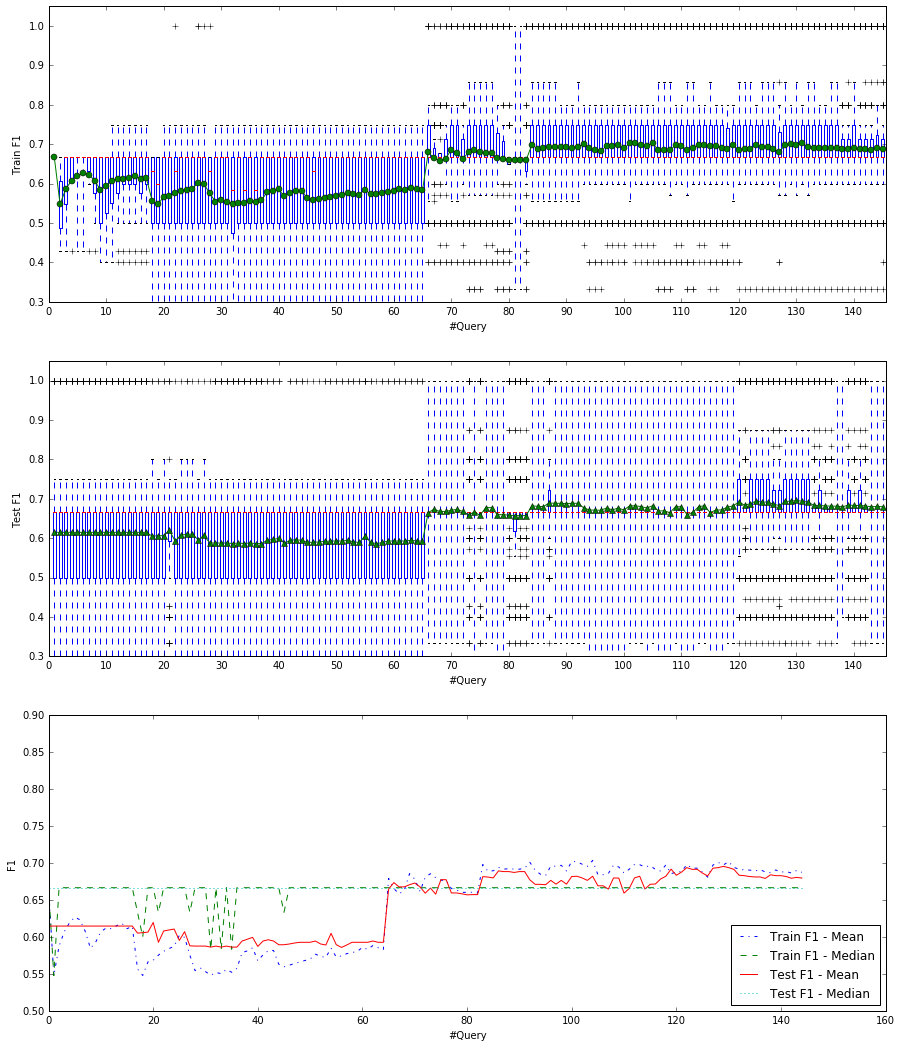

In [90]:
plot_evaluation_results(F1_rand_train, F1_rand_test)